In [1]:
# import required libraries
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

<h1>Data Preprocessing</h1>

In [2]:
data = pd.read_csv("churn.csv")

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


1) RowNumber, CustomerId and Surname are useless for building a model so we drop them

In [4]:
data.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)

2) One-Hot Encoding for categorical features

In [5]:
categorical_cols = ["Geography", "Gender", "Tenure", "NumOfProducts", "HasCrCard", "IsActiveMember"]
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_data = encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))
encoded_data = pd.concat([data.drop(categorical_cols, axis=1), encoded_df], axis=1)

In [6]:
encoded_data.head()

,CreditScore,Age,Balance,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,Tenure_1,Tenure_2,...,Tenure_6,Tenure_7,Tenure_8,Tenure_9,Tenure_10,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_1,IsActiveMember_1
0,619,42,0.00,101348.88,1,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,608,41,83807.86,112542.58,0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,502,42,159660.80,113931.57,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,699,39,0.00,93826.63,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,850,43,125510.82,79084.10,0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


3) Split train and validation data

In [7]:
X = encoded_data.drop(["Exited"], axis=1)
y = encoded_data["Exited"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y,     #to avoid imbalance in target values
                                                    random_state=78)

<H1>Choosing a scoring metric</H1>

- We cannot use accuracy as our metric because there is a high imbalance in the target class - only 20% of clients are exited
- From a business perspective both False-Negative and False-Positive errors are  important. The company needs to identify as many customers as possible who are going to leave, but shouldn't identify loyal customers as those who could potentially leave
- In this case, the best metric probably would be **F1_score**. This metric is good because it keeps the balance between precision and recall

<h1>Model selection</h1>

In addition to accuracy, **interpretability** of the model is very important for business
We will compare 3 different models: 
- Logistic Regression
- Random Forest
- Gradient Boosting

<H1>Logistic Regression</H1>

Logistic Regression is a linear model. It means that we need to bring all numerical features to a single scale

In [9]:
numerical_cols = ["CreditScore", "Age", "Balance", "EstimatedSalary"]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(encoded_data[numerical_cols])
scaled_df = pd.DataFrame(scaled_data, columns=numerical_cols)
final_scaled_data = pd.concat([encoded_data.drop(numerical_cols, axis=1), scaled_df], axis=1)

In [10]:
X_scaled = final_scaled_data.drop(["Exited"], axis=1)
y_scaled = final_scaled_data["Exited"]

In [11]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, 
                                                    test_size=0.2, 
                                                    stratify=y_scaled,     #to avoid imbalance in target values
                                                    random_state=78)

<h3>Base model</h3>

In [12]:
logistic_regression_base = LogisticRegression(random_state=78)
logistic_regression_base.fit(X_train_scaled, y_train_scaled);

In [13]:
logistic_regression_base_prediction = logistic_regression_base.predict(X_test_scaled)
logistic_regression_base_F1_score = f1_score(y_test_scaled, logistic_regression_base_prediction)
print(f'F1_score = {logistic_regression_base_F1_score:.2f}')

F1_score = 0.50


<H3>Selection of hyperparameters of regularization</H3>

Besides, we will use *class_weight="balanced"* due to imbalance in target values

In [14]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid = GridSearchCV(LogisticRegression(class_weight="balanced", random_state=78), param_grid, cv=5)
grid.fit(X_train_scaled, y_train_scaled)
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


<h3>Improved model</h3>

In [15]:
logistic_regression_improved = LogisticRegression(C=0.1, penalty="l1", solver="liblinear", class_weight="balanced", random_state=78)
logistic_regression_improved.fit(X_train_scaled, y_train_scaled);

In [16]:
logistic_regression_improved_prediction = logistic_regression_improved.predict(X_test_scaled)
logistic_regression_improved_F1_score = f1_score(y_test_scaled, logistic_regression_improved_prediction)
print(f'F1_score = {logistic_regression_improved_F1_score:.2f}')

F1_score = 0.55


<h3>Calibration of the Classification Threshold</h3>

In [17]:
y_pred_proba = logistic_regression_improved.predict_proba(X_test_scaled)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test_scaled, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best threshold: {best_threshold:.2f}")

Best threshold: 0.64


<h3>Final result</h3>

In [18]:
logistic_regression_prediction = (y_pred_proba >= best_threshold).astype(int)
logistic_regression_F1_score = f1_score(y_test_scaled, logistic_regression_prediction)
print(f'Final F1_score = {logistic_regression_F1_score:.2f}')

Final F1_score = 0.58




<h1>RandomForestClassifier</h1>

<h3>Base model</h3>

In [19]:
RFC_base = RandomForestClassifier(random_state=78)
RFC_base.fit(X_train, y_train);

In [20]:
RFC_base_prediction = RFC_base.predict(X_test)
RFC_base_F1_score = f1_score(y_test, RFC_base_prediction)
print(f'F1_score = {RFC_base_F1_score:.2f}')

F1_score = 0.58


<H3>Selection of hyperparameters</H3>

In [21]:
RFC_param_grid = {
    "n_estimators": [100, 200, 400],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 3, 4, 5],
}
RFC_grid = GridSearchCV(RandomForestClassifier(random_state=78), RFC_param_grid, cv=5)
RFC_grid.fit(X_train, y_train)
print("Best parameters:", RFC_grid.best_params_)

Best parameters: {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 200}


<h3>Improved model</h3>

In [22]:
RFC_improved = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=3, random_state=78)
RFC_improved.fit(X_train, y_train);

In [23]:
RFC_improved_prediction = RFC_improved.predict(X_test)
RFC_improved_F1_score = f1_score(y_test, RFC_improved_prediction)
print(f'F1_score = {RFC_improved_F1_score:.2f}')

F1_score = 0.57


<h3>Calibration of the Classification Threshold</h3>

In [24]:
RFC_y_pred_proba = RFC_improved.predict_proba(X_test)[:, 1]
RFC_precisions, RFC_recalls, RFC_thresholds = precision_recall_curve(y_test, RFC_y_pred_proba)
RFC_f1_scores = 2 * (RFC_precisions * RFC_recalls) / (RFC_precisions + RFC_recalls)
RFC_best_threshold = RFC_thresholds[np.argmax(RFC_f1_scores)]
print(f"Best threshold: {RFC_best_threshold:.2f}")

Best threshold: 0.30


<h3>Final result</h3>

In [25]:
RFC_prediction = (RFC_y_pred_proba >= RFC_best_threshold).astype(int)
RFC_F1_score = f1_score(y_test, RFC_prediction)
print(f'Final F1_score = {RFC_F1_score:.2f}')

Final F1_score = 0.64


<h1>XGBoost_Classifier</h1>

<h3>Base model</h3>

In [26]:
xgb_base = xgb.XGBClassifier(objective="binary:logistic", random_state=78)
xgb_base.fit(X_train, y_train);

In [27]:
xgb_base_prediction = xgb_base.predict(X_test)
xgb_base_F1_score = f1_score(y_test, xgb_base_prediction)
print(f'F1_score = {xgb_base_F1_score:.2f}')

F1_score = 0.59


<H3>Selection of hyperparameters</H3>

Here we will use *scale_pos_weight=4* due to 80:20 imbalance in target values

In [28]:
xgb_param_grid = {
    "n_estimators" : [50, 100, 500, 1000, 1500],
    "max_depth": [3, 5, 7],  
    "learning_rate": [0.01, 0.05, 0.1, 0.3],
    "subsample": [0.6, 0.8, 1.0]
}
xgb_grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic", scale_pos_weight=4, random_state=78),
                           param_grid=xgb_param_grid,
                           scoring="f1",
                           cv=5,                                    
                           n_jobs=-1,                                  
                           verbose=1
                          )
xgb_grid_search.fit(X_train, y_train)
print("Best parameter:", xgb_grid_search.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameter: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.6}


<h3>Improved model</h3>

In [29]:
xgb_improved = xgb.XGBClassifier(objective="binary:logistic",
                                   learning_rate=0.01, 
                                   max_depth=5, 
                                   n_estimators=500, 
                                   subsample=0.6, 
                                   random_state=78,
                                   scale_pos_weight=4,
                                )
xgb_improved.fit(X_train, y_train);

In [30]:
xgb_improved_prediction = xgb_improved.predict(X_test)
xgb_improved_F1_score = f1_score(y_test, xgb_improved_prediction)
print(f'F1_score = {xgb_improved_F1_score:.2f}')

F1_score = 0.62


<h3>Calibration of the Classification Threshold</h3>

In [31]:
xgb_y_pred_proba = xgb_improved.predict_proba(X_test)[:, 1]
xgb_precisions, xgb_recalls, xgb_thresholds = precision_recall_curve(y_test, xgb_y_pred_proba)
xgb_f1_scores = 2 * (xgb_precisions * xgb_recalls) / (xgb_precisions + xgb_recalls)
xgb_best_threshold = xgb_thresholds[np.argmax(xgb_f1_scores)]
print(f"Best threshold: {xgb_best_threshold:.2f}")

Best threshold: 0.66


<h3>Final result</h3>

In [32]:
xgb_prediction = (xgb_y_pred_proba >= xgb_best_threshold).astype(int)
xgb_F1_score = f1_score(y_test, xgb_prediction)
print(f'Final F1_score = {xgb_F1_score:.2f}')

Final F1_score = 0.65


<h1>Interpretation of results</h1>

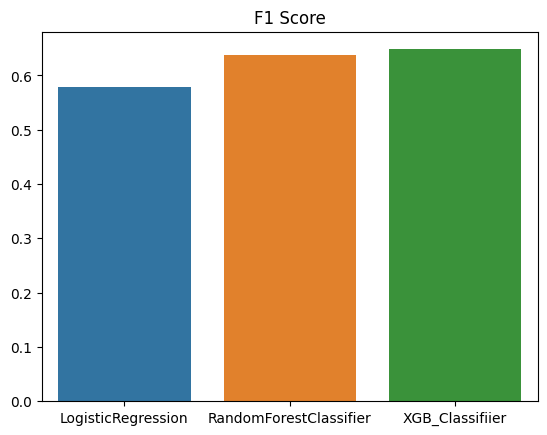

In [33]:
comparison = pd.DataFrame({"LogisticRegression" :  [logistic_regression_F1_score],
                           "RandomForestClassifier" : [RFC_F1_score],
                           "XGB_Classifiier" : [xgb_F1_score]})
sns.barplot(comparison)
plt.title("F1 Score");

Comparing 3 models, we can conclude that Gradient Boosting shows the best results in our case

<h3>Classification report</h3>

In [34]:
print(classification_report(y_test, xgb_prediction))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1593
           1       0.67      0.63      0.65       407

    accuracy                           0.86      2000
   macro avg       0.79      0.77      0.78      2000
weighted avg       0.86      0.86      0.86      2000



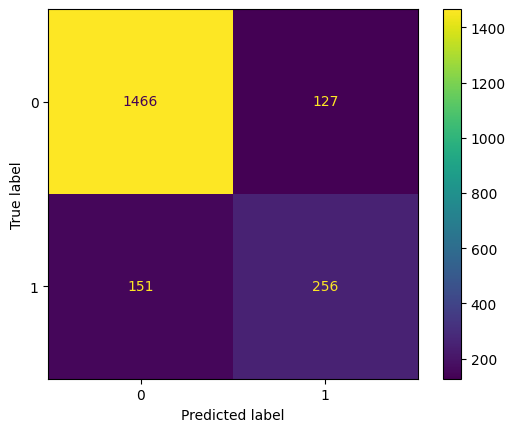

In [35]:
cm = confusion_matrix(y_test, xgb_prediction)
disp = ConfusionMatrixDisplay(cm)
disp.plot();

<h3>Feature importance</h3>

**The number of times a feature appears in a tree**

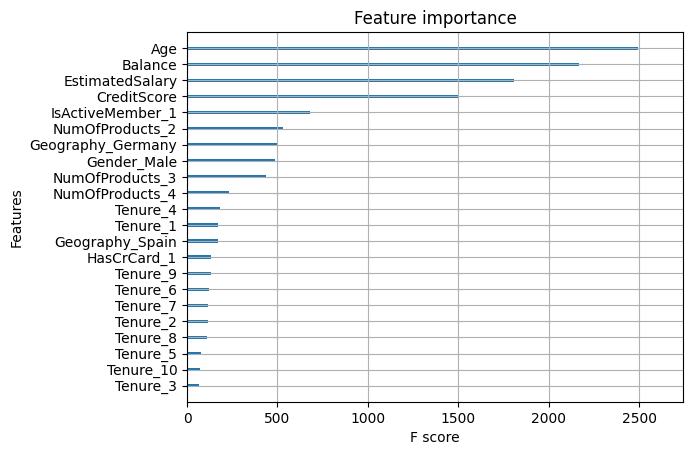

In [36]:
xgb.plot_importance(xgb_improved, show_values=False);

**The average gain of splits which use the feature**

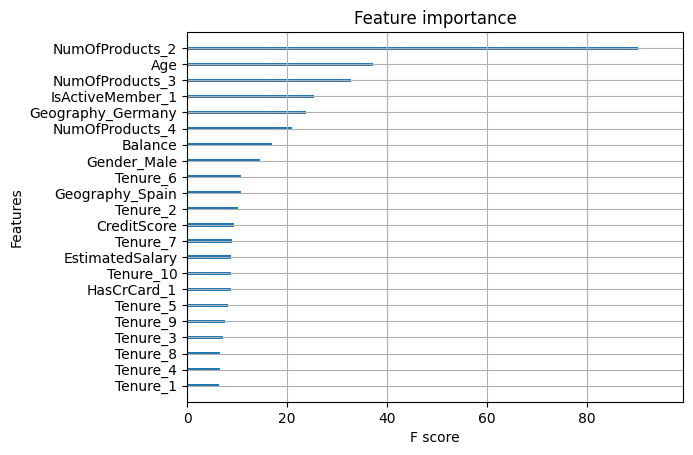

In [37]:
xgb.plot_importance(xgb_improved, show_values=False, importance_type="gain");

<h3>SHAP analysis</h3>

In [38]:
explainer = shap.TreeExplainer(xgb_improved)
shap_values = explainer.shap_values(X_test)

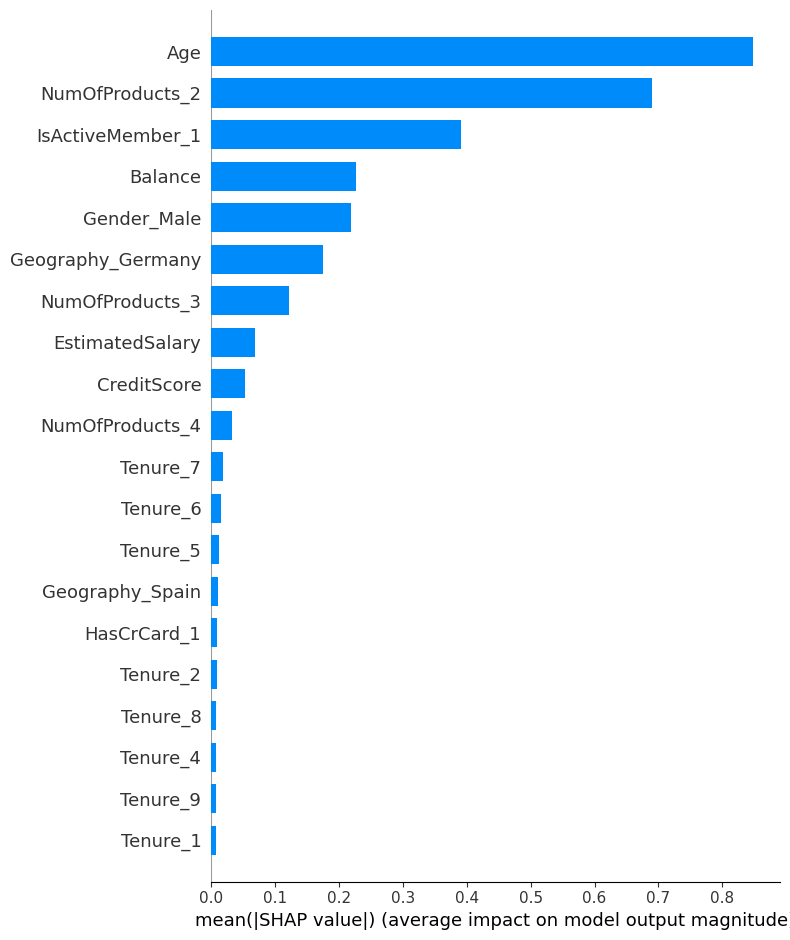

In [39]:
shap.summary_plot(shap_values, X_test, plot_type="bar") 

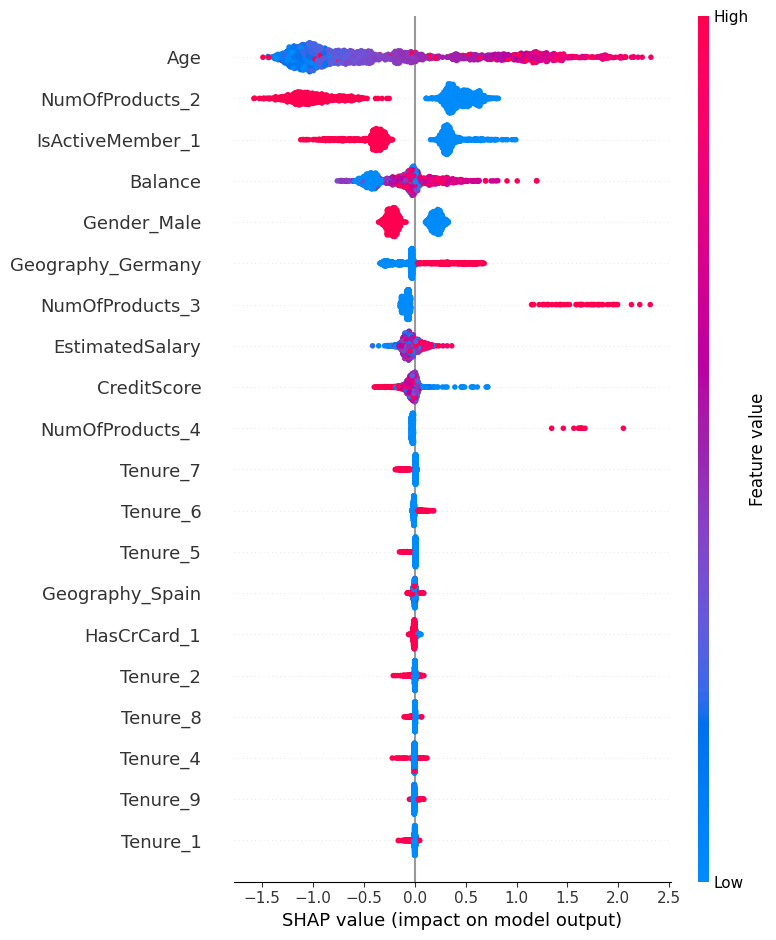

In [40]:
shap.summary_plot(shap_values, X_test)  

<h1>Saving model</h1>

In [41]:
joblib.dump(xgb_improved, 'churn_model.pkl')
joblib.dump(X_train, 'train_data.pkl');